# Analisi bayesiana dell'odds-ratio

Esaminiamo qui un esercizio che utilizza gli strumenti statistici descritti nei capitoli precedenti in relazione all'analisi bayesiana di due proporzioni.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
import seaborn as sns
import arviz as az
import pymc as pm
from scipy.constants import golden

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
sns.set(color_codes=True)
az.style.use("arviz-darkgrid")
sns.set_theme(
    context="paper",
    palette="colorblind",
)

In questo esercizio considereremo come dati i voti del primo parziale di Psicometria, AA 2022-2023. Esamineremo i dati in funzione del genere. Verranno qui considerati i due seguenti eventi dicotomici:

- avere impiegato un tempo maggiore della media per concludere l'esame,
- avere ottenuto i voti più alti (>=30)

Svolgeremo qui un esercizio relativo all'analisi dei dati relativi alla proporzione di studenti che, nella consegna del primo parziale, hanno impiegato un tempo maggiore della media (87.2217 minuti). I dati del secondo punto sono forniti alla fine del capitolo e vengono lasciati come esercizio da svolgere in autonomia.

I dati relativi al primo punto sono i seguenti. Hanno impiegato un tempo maggiore della media 
- 108 femmine su 155 
- 28 maschi su 57 

Per confrontare la prestazione dei due gruppi useremo l'*odds ratio*. Iniziamo a definire il concetto di odds.

## Odds

Con il termine odds si intende il rapporto tra la probabilità $p$ di un evento e la probabilità che tale evento non accada, cioè la probabilità $1-p$ dell'evento complementare:

$$
odds = \frac{p}{1-p}.
$$

Per esempio, con una probabilità di $p$ = 0.8, otteniamo 

In [3]:
p = 0.8
p / (1 - p)

4.000000000000001

un odds di 4. Questo significa che ci sono 4 "successi" per ciascun insuccesso, ovvero gli odds di successo sono 4 a 1. Se la probabilità di successo è 0.5, questo significa che indica che successo ed insuccesso hanno la stessa probabilità di accadere, ovvero gli odds di successo sono 1 a 1. 

L'odds è un numero compreso tra 0 e più infinito. 

Uno dei motivi per usare gli odds invece della probabilità, che è un un concetto più intuitivo, è che quando le probabilità si avvicinano molto ai valori estremi (cioè allo 0% oppure al 100%), è più facile cogliere le differenze tra odds che le differenze tra le probabilità. 

Esaminiamo la relazione tra odds e probabilità.

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_60226/1852432908.py:2: RuntimeWarning: divide by zero encountered in divide
  odds = p / (1 - p)


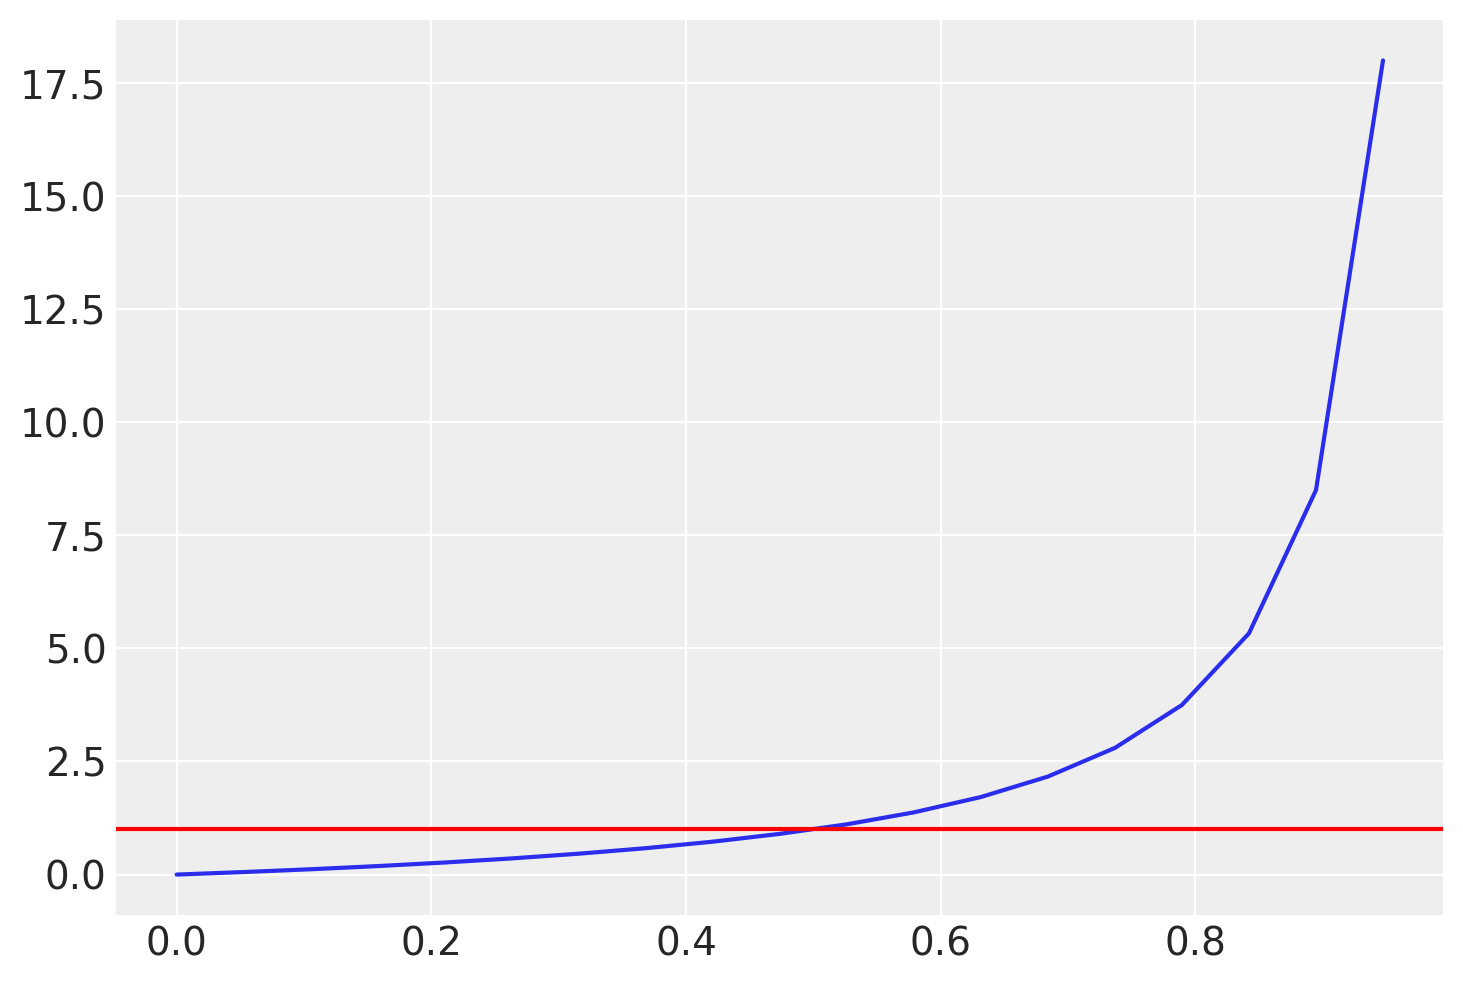

In [4]:
p = np.linspace(0, 1, 20)
odds = p / (1 - p) 

plt.plot(p, odds)
plt.axhline(y = 1, color = 'r', linestyle = '-')

## Odds ratio

Quando la variabile di interesse è una proporzione, il confronto tra gruppi può essere eseguito mediante l'odds ratio. L'odds ratio è il rapporto tra gli odds di un evento in un gruppo e gli odds dello stesso evento in un secondo gruppo:

$$
OR = \frac{odds_1}{odds_2} = \frac{p_1/(1-p_1)}{p_2/(1-P-2)}.
$$

Interpretazione:

- OR = 1: l'appartenenza al gruppo non influenza il risultato
- OR > 1: l'appartenenza al gruppo specificato al numeratore dell'OR è rende maggiori gli odds del risultato 
- OR < 1: l'appartenenza al gruppo specificato al numeratore dell'OR è rende minori gli odds del risultato 

Consideriamo i dati del primo parziale. 

In [5]:
n1 = 155 # femmine
y1 = 108
n2 = 57 # maschi
y2 = 28

Per le femmine, gli odds di impiegare un tempo maggiore della media sono:

In [6]:
# femmine
p_f = 108 / 155
odds_f = p_f / (1 - p_f)
odds_f


2.297872340425532

Ciò significa che, per le femmine, ci sono circa due "successi" (impiegare un tempo maggiore della media) per ogni "insuccesso" (impiegare un tempo minore della media). 


Per i maschi, gli odds di impiegare un tempo maggiore della media sono:

In [7]:
# maschi
p_m = 28 / 57
odds_m = p_m / (1 - p_m)
odds_m

0.9655172413793103

Ciò significa che, per i maschi, c'è circa lo stesso numero di "successi" (impiegare un tempo maggiore della media) e "insuccessi" (impiegare un tempo minore della media). 

Calcoliamo l'OR:

In [8]:
OR = odds_f / odds_m
OR 

2.379939209726444

Un odds ratio di circa 2 ci dice che gli odds di "successo" (impiegare un tempo maggiore della media) sono circa il doppio per le femmine che per i maschi.

## Inferenza

L'OR descrive le proprietà del campione esaminato. In questo particolare campione, l'OR è circa 2 per le femmine rispetto ai maschi. Ma in altri campioni la situazione cambierà. Questo fenomeno è chiamato "variabilità campionaria". 

Alla luce del fenomeno della "variabilità campionaria", si pone il problema dell'inferenza: non siamo interessati alle specifiche caratteristiche del campione esaminato (ovvero, alle caratteristiche che sono solo proprie di un particolare campione), ma siamo invece interessati delle caratteristiche del *fenomeno generale*, ovvero di ciò che è comune a tutti i campioni (le caratteristiche della popolazione statistica). 

Ci chiediamo se la differenza tra maschi e femmine che abbiamo osservato in questo campione, ovvero un OR = 2.38, sia *credibile*, ovvero sia qualcosa che ci aspettiamo in generale, *per gli esami di questo tipo*, oppure se è qualcosa sia specifico a questo particolare campione.

Per rispondere a questa domanda useremo l'approccio bayesiano, ovvero costruiremo la distribuzione a posteriori dell'odds-ratio. Poniamo di scegliere un livello di credibilità di 0.9. Diremo che riteniamo il risultato credibile -- ovvero, generalizzabile al di là di questo particolare campione -- se l'intervallo di credibilità al livello prefissato non include il valore di 1. 

In [9]:
with pm.Model() as model:
    # Define the priors for the two proportions
    p1 = pm.Beta("p1", alpha=2, beta=2)
    p2 = pm.Beta("p2", alpha=2, beta=2)

    # Define the likelihood functions for the two proportions
    likelihood1 = pm.Binomial("likelihood1", n=n1, p=p1, observed=y1)
    likelihood2 = pm.Binomial("likelihood2", n=n2, p=p2, observed=y2)

    # Define the difference of odds model
    odds_ratio = pm.Deterministic("odds_ratio", (p1 / (1 - p1)) / (p2 / (1 - p2)))

In [10]:
with model:
    trace = pm.sample(draws=2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p1, p2]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


## Diagnostica delle catene markoviane

Prima di esaminare i risultati, eseguiamo la diagnostica delle catene markoviane.

### Mixing

Il trace plot precedente dimostra un buon mixing. Questo è evidenza che il campionamento MCMC ha raggiunto uno stato stazionario.


array([[<Axes: title={'center': 'p1'}>, <Axes: title={'center': 'p1'}>],
       [<Axes: title={'center': 'p2'}>, <Axes: title={'center': 'p2'}>],
       [<Axes: title={'center': 'odds_ratio'}>,
        <Axes: title={'center': 'odds_ratio'}>]], dtype=object)

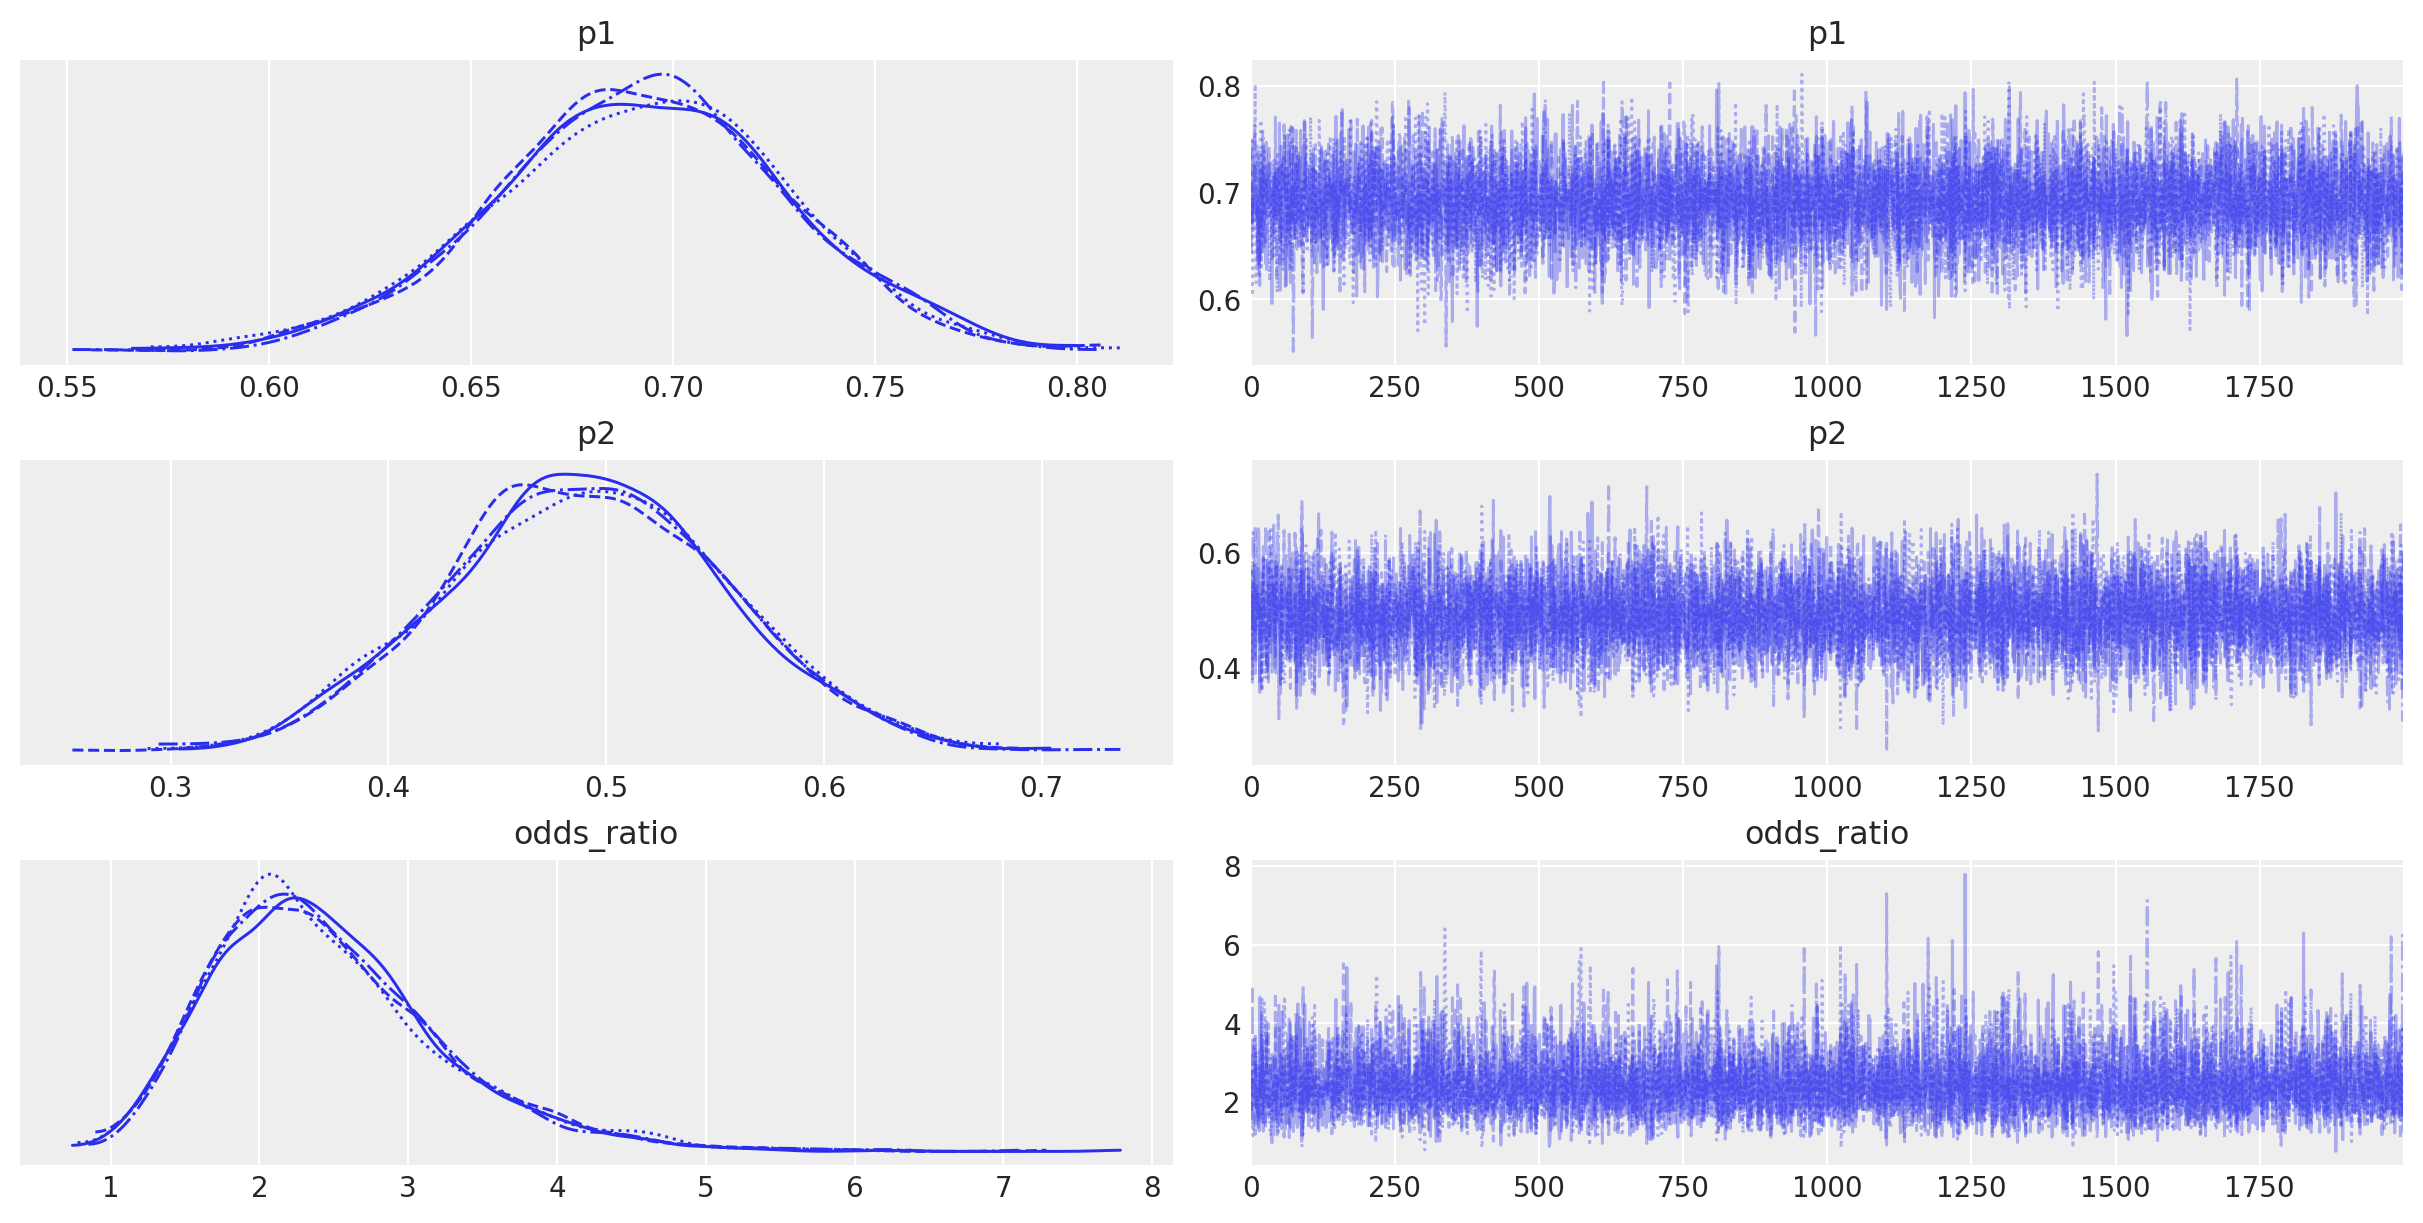

In [11]:
az.plot_trace(trace)

### Numerosità campionaria effettiva

Quando si utilizzano metodi di campionamento MCMC, è ragionevole chiedersi se un particolare campione estratto dalla distribuzione a posteriori sia sufficientemente grande per calcolare con sicurezza le quantità di interesse, come una media o un HDI. Questo non è qualcosa che possiamo rispondere direttamente guardando solo il numero di punti della catena MCMC, e il motivo è che i campioni ottenuti dai metodi MCMC hanno un certo grado di autocorrelazione, quindi la quantità effettiva di informazioni contenute in quel campione sarà inferiore a quella che otterremmo da un campione iid della stessa dimensione. Possiamo pensare alla dimensione del campione effettivo (ESS) come a un stimatore che tiene conto dell’autocorrelazione e fornisce il numero di estrazioni che avremmo se il nostro campione fosse effettivamente iid.

Per le catene buone, solitamente, il valore della dimensione del campione effettivo sarà inferiore al numero di campioni. Ma l’ESS può essere in realtà più grande del numero di campioni estratti. Quando si utilizza il campionatore NUTS, valori di ESS maggiori del numero totale di campioni possono verificarsi per parametri le cui distribuzioni posteriori sono vicine alla Gaussiana e che sono quasi indipendenti da altri parametri nel modello.

Nell'output di PyCM si considera ESS_BULK.  Un euristica è che deve essere almeno uguale a 400. Nel caso presente questo si verifica.

### R hat

In condizioni molto generali, i metodi di Markov chain Monte Carlo hanno garanzie teoriche che otterranno la risposta corretta indipendentemente dal punto di partenza. Sfortunatamente, tali garanzie sono valide solo per campioni infiniti. Quindi, nella pratica, abbiamo bisogno di modi per stimare la convergenza per campioni finiti. Un’idea diffusa è quella di generare più di una catena, partendo da punti molto diversi e quindi controllare le catene risultanti per vedere se sembrano simili tra loro. Questa nozione intuitiva può essere formalizzata in un indicatore numerico noto come R-hat. Esistono molte versioni di questo stimatore, poiché è stato perfezionato nel corso degli anni. In origine il R-hat veniva interpretato come la sovrastima della varianza dovuta al campionamento MCMC finito. Ciò significa che se si continua a campionare all’infinito si dovrebbe ottenere una riduzione della varianza della stima di un fattore R-hat. E quindi il nome “fattore di riduzione potenziale della scala” (*potential scale reduction factor*), con il valore target di 1 che significa che aumentare il numero di campioni non ridurrà ulteriormente la varianza della stima. Tuttavia, nella pratica è meglio pensarlo solo come uno strumento diagnostico senza cercare di sovra-interpretarlo.

L’R-hat per il parametro theta viene calcolato come la deviazione standard di tutti i campioni di theta, ovvero includendo tutte le catene insieme, diviso per la radice quadratica media delle deviazioni standard separate all’interno della catena. Il calcolo effettivo è un po’ più complesso ma l’idea generale è questa. Idealmente dovremmo ottenere un valore di 1, poiché la varianza tra le catene dovrebbe essere la stessa della varianza all’interno della catena. Da un punto di vista pratico, valori di R-hat inferiori a 1.1 sono considerati sicuri.

Nel caso presente questo si verifica.

Possiamo ottenere R hat con Arviz:


In [67]:
az.rhat(trace)

<xarray.Dataset>
Dimensions:     ()
Data variables:
    p1          float64 1.001
    p2          float64 1.001
    odds_ratio  float64 1.001

### Errore Standard di Monte Carlo 

Quando si utilizzano metodi MCMC introduciamo un ulteriore livello di incertezza poiché stiamo approssimando la posteriore con un numero finito di campioni. Possiamo stimare la quantità di errore introdotta utilizzando l’errore standard di Monte Carlo (MCSE). L’MCSE tiene conto del fatto che i campioni non sono veramente indipendenti l’uno dall’altro e sono in realtà calcolati dall’ESS. Mentre i valori di ESS e R-hat sono indipendenti dalla scala dei parametri, la statistica MCSE non lo è. Se vogliamo riportare il valore di un parametro stimato al secondo decimale, dobbiamo essere sicuri che MCSE sia al di sotto del secondo decimale altrimenti, finiremo, erroneamente, per riportare una precisione superiore a quella che abbiamo realmente. Dovremmo controllare MCSE solo una volta che siamo sicuri che ESS sia abbastanza alto e R-hat sia abbastanza basso; altrimenti, MCSE non è utile.

Nel nostro caso il MCSE è sufficientemente piccolo.

In [69]:
az.mcse(trace)

<xarray.Dataset>
Dimensions:     ()
Data variables:
    p1          float64 0.0004084
    p2          float64 0.0007191
    odds_ratio  float64 0.008659

Come per l’ESS, l’MCSE varia nello spazio dei parametri e quindi potremmo anche volerlo valutare per diverse regioni dello spazio dei parametri.

array([<Axes: title={'center': 'p1'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
       <Axes: title={'center': 'p2'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
       <Axes: title={'center': 'odds_ratio'}, xlabel='Quantile', ylabel='MCSE for quantiles'>],
      dtype=object)

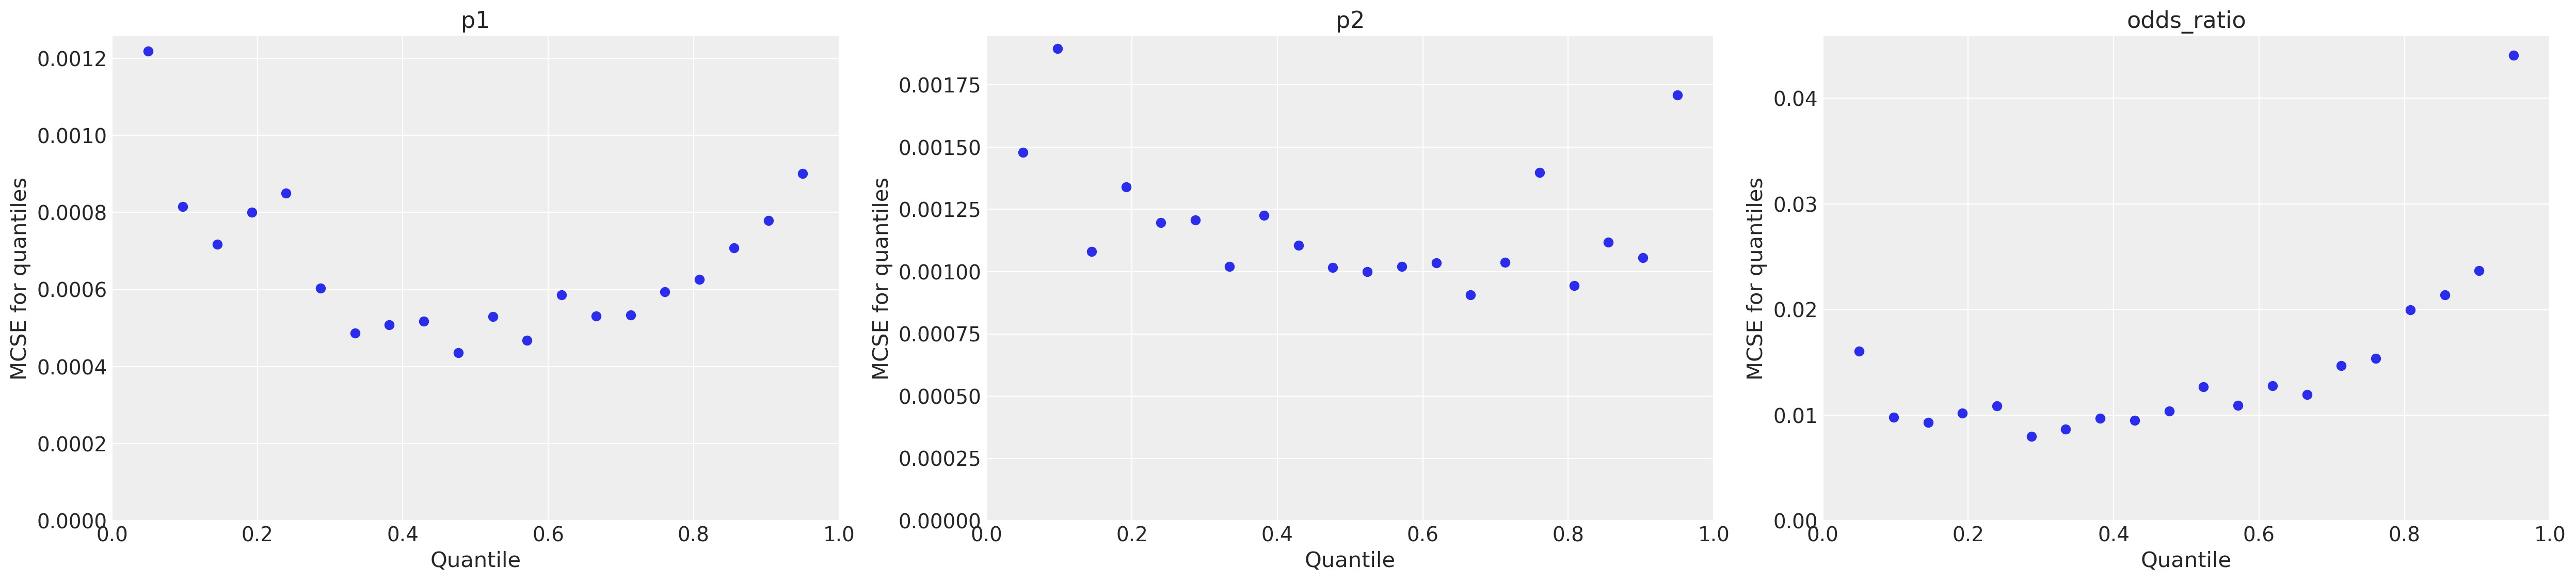

In [70]:
az.plot_mcse(trace)

### Autocorrelazione

L’autocorrelazione riduce la quantità effettiva di informazioni contenute in un campione e quindi è qualcosa che vogliamo mantenere al minimo. Possiamo ispezionare direttamente l’autocorrelazione con `az.plot_autocorr`.

array([<Axes: title={'center': 'p1'}>, <Axes: title={'center': 'p2'}>,
       <Axes: title={'center': 'odds_ratio'}>], dtype=object)

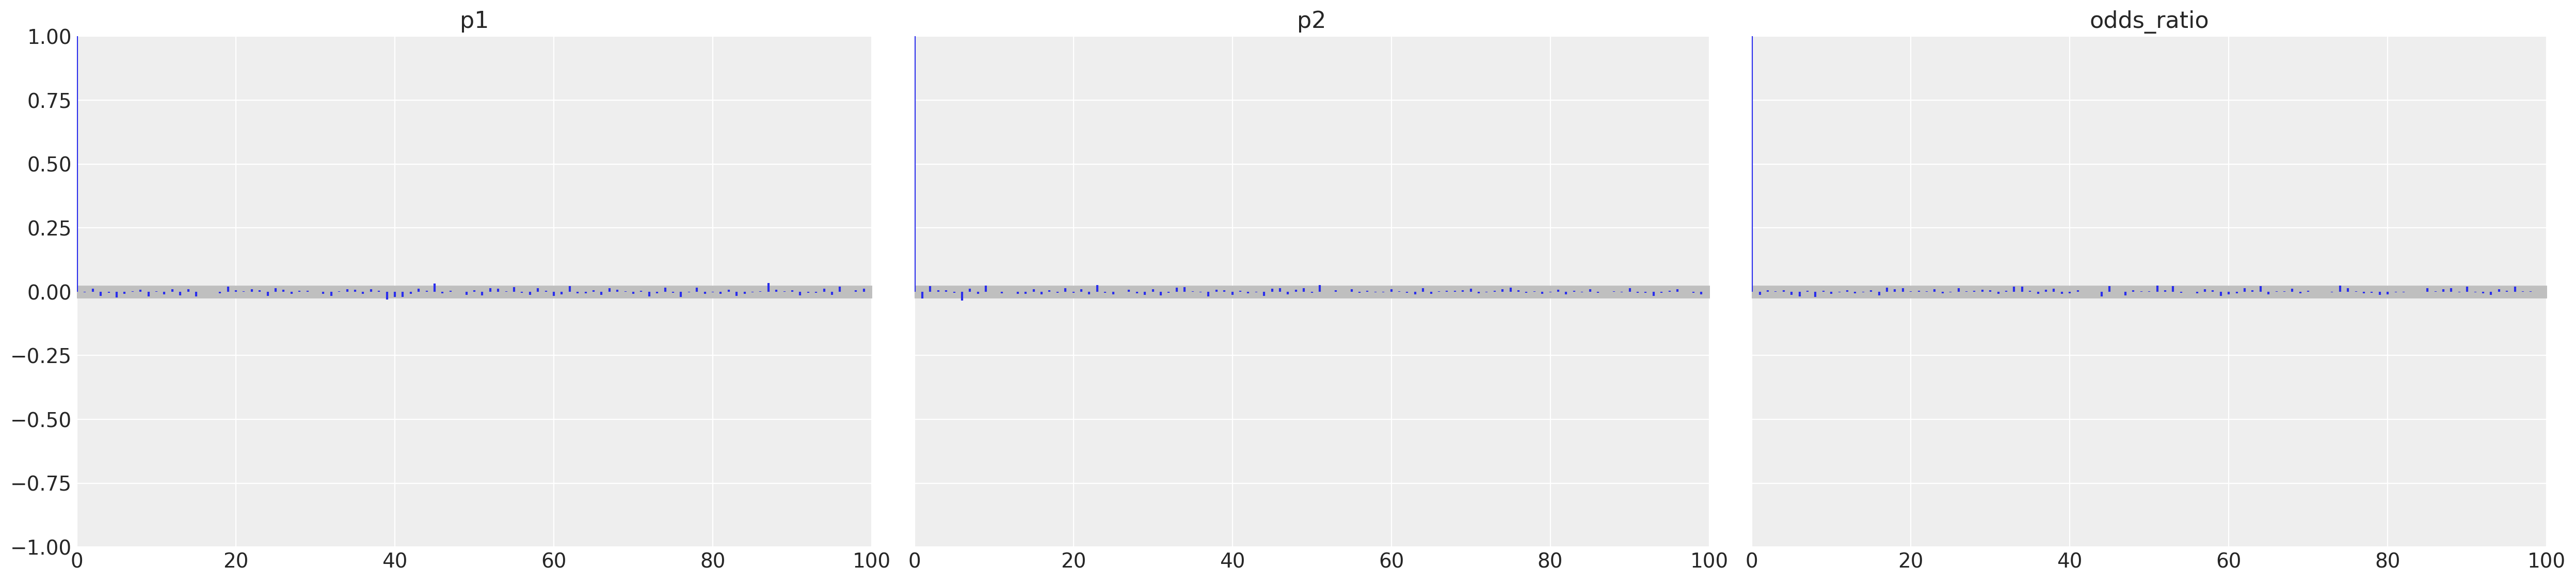

In [71]:
az.plot_autocorr(trace, combined=True)

### Rank Plots

I grafici dei ranghi sono un altro strumento diagnostico visivo che possiamo utilizzare per confrontare il comportamento del campionamento sia all’interno che tra le catene. I grafici dei ranghi, in parole semplici, sono istogrammi dei campioni della distribuzione a posteriori espressi in termini di ranghi. 

In statistica, il “rango” di un’osservazione è la sua posizione in un insieme di dati ordinati. Ad esempio, consideriamo il seguente insieme di dati: [5, 3, 8, 10]. Se ordiniamo questi dati in ordine crescente otterremo [3, 5, 8, 10]. In questo caso, il rango del numero 5 è 2 perché è il secondo numero nell’insieme ordinato. Allo stesso modo, il rango del numero 10 è 4 perché è il quarto numero nell’insieme ordinato.

Nei grafici dei ranghi, i ranghi sono calcolati combinando prima tutte le catene ma poi rappresentando i risultati separatamente per ogni catena. Se tutte le catene stimano la stessa distribuzione, ci aspettiamo che i ranghi abbiano una distribuzione uniforme. Inoltre, se i grafici dei ranghi di tutte le catene sembrano simili, ciò indica un buon mix delle catene.

Possiamo ottenere i grafici dei ranghi con `az.plot_rank`.

array([<Axes: title={'center': 'p1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'p2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'odds_ratio'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

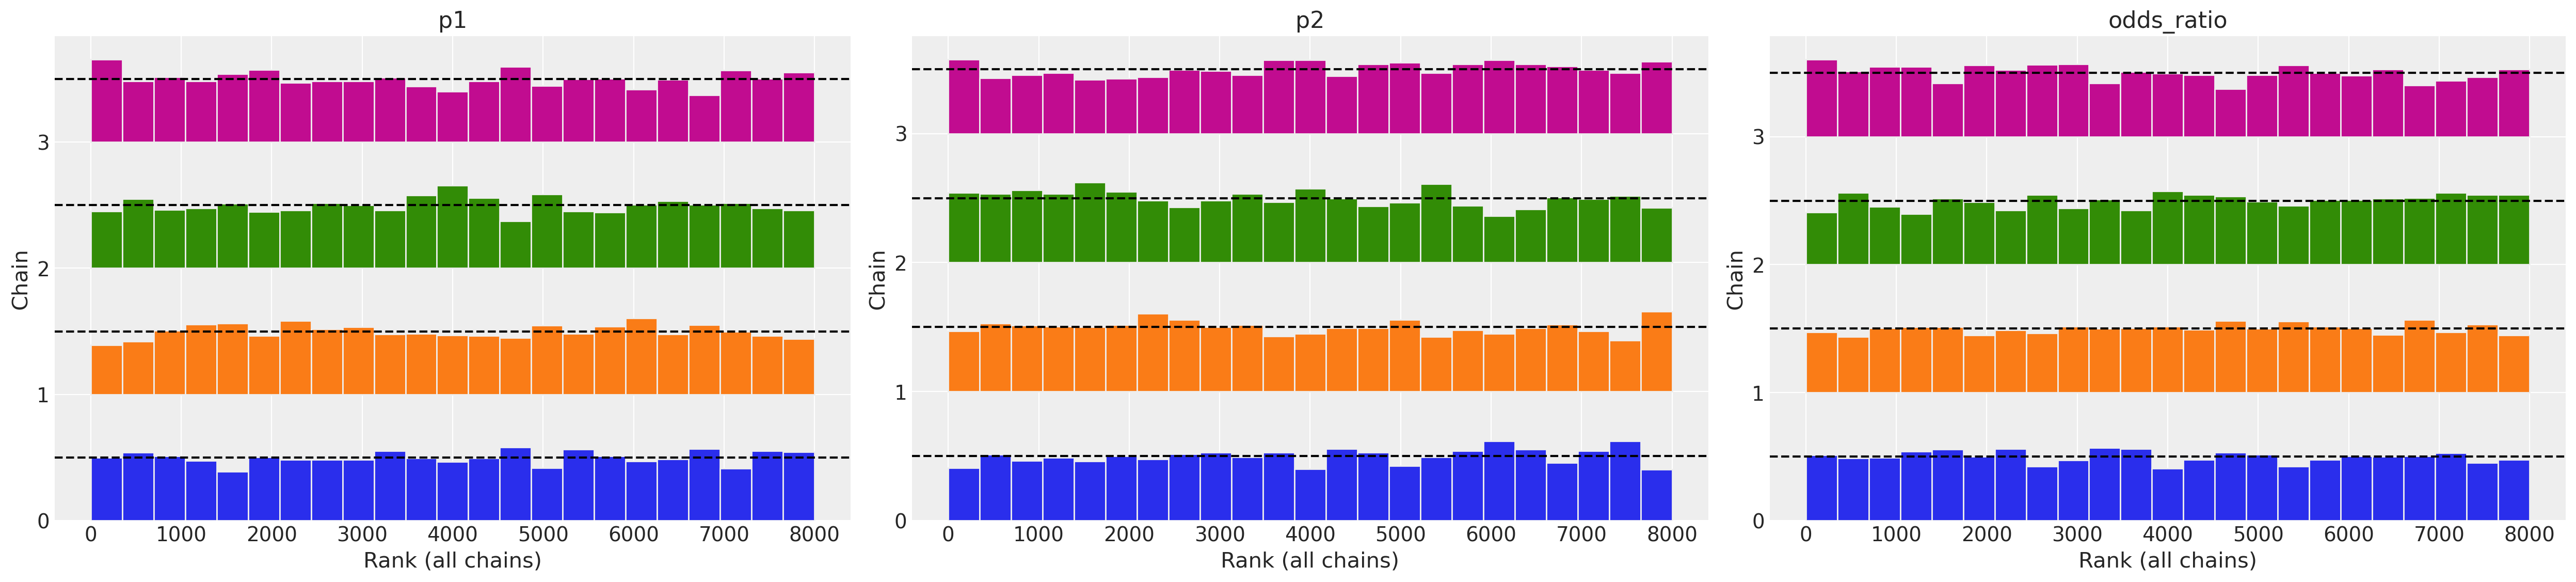

In [73]:
az.plot_rank(trace, kind="bars")


Una rappresentazione alternativa è la seguente.

array([<Axes: title={'center': 'p1'}, xlabel='Rank (all chains)'>,
       <Axes: title={'center': 'p2'}, xlabel='Rank (all chains)'>,
       <Axes: title={'center': 'odds_ratio'}, xlabel='Rank (all chains)'>],
      dtype=object)

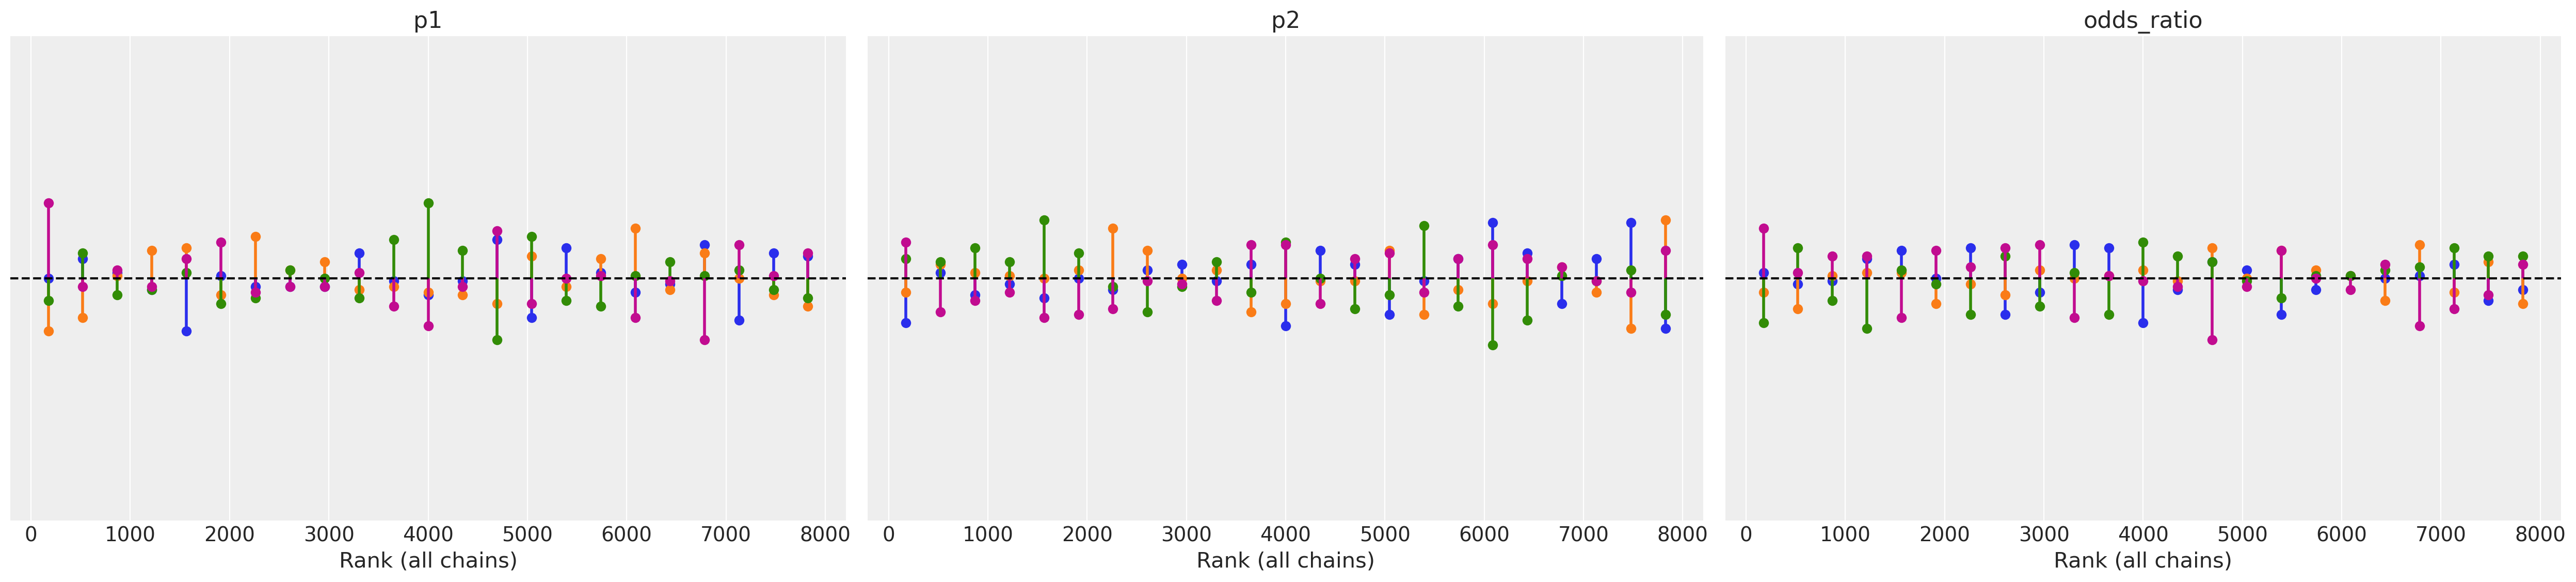

In [74]:
az.plot_rank(trace, kind="vlines")

Possiamo vedere nella figura che i ranghi sono molto simili ad una distribuzione uniforme e che tutte le catene sono simili tra loro senza alcuno scostamento distintivo.

### Divergenza

Finora abbiamo diagnosticato il funzionamento di un campionatore esaminando i campioni generati. Un altro modo per eseguire una diagnosi è monitorare il comportamento dei meccanismi interni del metodo di campionamento. Un esempio importante di tali diagnosi è il concetto di divergenza presente in alcuni metodi Hamiltonian Monte Carlo (HMC). Le divergenze (o transizioni divergenti) sono un modo potente e sensibile per diagnosticare i campioni e funzionano come complemento alle diagnosi che abbiamo visto nelle sezioni precedenti. 

PyMC riporta il numero di transizioni divergenti. Se non viene riportato alcun messaggio che informa della presenza di transizioni divergenti, questo vuol dire che la distribuzione a posteriori è stata stimata correttamente.

## Risultati

Dato i risultati della diagnostica delle catene markoviane non rivela alcun problema con la convergenza dell'algoritmo o con il modello statistico esaminato, passiamo ad esaminare i risultati.

In [12]:
az.summary(trace, hdi_prob=0.90, round_to=3)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p1,0.692,0.036,0.635,0.754,0.000,0.000,8767.318,5617.962,1.001
p2,0.491,0.064,0.385,0.595,0.001,0.001,8081.072,6158.645,1.000
odds_ratio,2.455,0.781,1.286,3.668,0.009,0.007,8196.906,6255.131,1.000


Si noti il valore di $\hat{R}$ che, al massimo, raggiunge il valore di 1.001.  Questa è la più importante statistica di convergenza dell'algoritmo MCMC.  Essendo il valore molto simile a 1 nel caso presente, possiamo dire che non ci sono evidenza di assenza di convergenza.

Il valore ESS_BULK non fornisce alcuna evidenza di cattivo mixing. Infatti, il valore è adirittura superiore al valore di  $N$ = 8000 che è il numero di campioni che sono stati estratti dalla distribuzione a posteriori. Emerge un problema di mixing se ESS_BULK è minore ad 1/10 di $N$, il che non è il caso qui.

L'errore standard di Monte Carlo ci informa della precisione della stima ottenuta usando il metodo MCMC. Non possiamo riportare una precisione dei risultati maggiore di quella indicata dalla MCSE. Quindi, nel caso presente per l'OR direi che due cifre decimali sono il massimo che si può fare.

È dunque possibile concludere che la stima a posteriori dell'OR è 2.45 con un intervallo di credibilità al 90% pari a 1.29, 3.67. Quindi concludiamo, con una certezza soggettiva di 0.9, che gli odds di impiegare un tempo superiore alla media hanno un valore minimo di circa 1.3 a 1 e un valore massimo di circa 3.7 a 1. Dato che l'intervallo di credibilità non include il valore 1, possiamo concludere, con relativa certezza che le femmine impiegano un tempo maggiore dei maschi nel completare un compito come quello esaminato.

## Limiti

Si noti che l'operazionalizzazione del tempo impiegato a completare il compito nei termini di un evento dicotomico (superiore alla media / inferiore alla media) è insoddisfacente, in quanto trascura la *quantificazione* della differenza. Una tale operazionalizzazione del tempo è stata utilizzata al solo scopo di fornire un esempio basato su un evento dicotomico. Più appropriato sarebbe stato analizzare i dati nei temini del tempo medio (es., in minuti) impiegato da maschi e femmine. 

Questo argomento sarà affrontato in uno dei capitoli successivi.

### Conclusione

Dato che l'intervallo di credibilità per l'OR non include il valore 1, concludiamo con un grado di certezza soggettiva del 90% che le femmine tendono ad impiegare un tempo maggiore della media rispetto ai maschi.  

Sarebbe stato più sensato confrontare direttamente il tempo impiegato dalle femmine e dai maschi.  Ma, dato che non abbiamo ancora coperto il tema del confronto tra medie, ho svolto l'analisi statistica confrontando due proporzioni.

## Esercizio 2

Hanno ottenuto i voti più alti (>=30)
- 15 femmine su 155
- 13 maschi su 57

Si confrontino i dati di maschi e femmine seguendo la procedura delineata sopra.

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w